In [6]:
import torch
import pickle
import numpy as np
from lambeq import BobcatParser, RemoveCupsRewriter, IQPAnsatz, AtomicType, PennyLaneModel
from discopy.rigid import Ty, Diagram, Box
import os

In [47]:
import torch
import numpy as np

def kl_divergence(p, q):
    """Compute KL(p || q) for two probability distributions."""
    p = np.array(p)
    q = np.array(q)

    # Add small epsilon to avoid log(0) issues
    epsilon = 1e-10
    p = p + epsilon
    q = q + epsilon

    kl = np.sum(p * np.log(p / q))
    return kl

def representativeness(p, q):
    """Compute representativeness R_KL(p, q)."""
    kl = kl_divergence(p, q)
    return 1 / (1 + kl)

def compare_embeddings(p, q, theta = 0.8):
    """Compare two embeddings: p vs q and q vs p."""
    # Normalize embeddings
    p = np.abs(vec1)
    p = p / np.sum(p)
    q = np.abs(vec2)
    q = q / np.sum(q)

    # Compute KL(p || q)
    kl_pq = kl_divergence(p, q)
    rkl_pq = representativeness(p, q)

    # Compute KL(q || p)
    kl_qp = kl_divergence(q, p)
    rkl_qp = representativeness(q, p)

    print(f"KL(p || q) = {kl_pq:.6f}")
    print(f"Representativeness R_KL(p || q) = {rkl_pq:.6f}")
    print(f"KL(q || p) = {kl_qp:.6f}")
    print(f"Representativeness R_KL(q || p) = {rkl_qp:.6f}")
    
    if rkl_pq >= theta:
        print(f"At threshold {theta}, p entails q.")
    else: 
        print(f"At threshold {theta}, p does not entails q.")
    if rkl_qp >= theta:
        print(f"At threshold {theta}, q entails p.")
    else: 
        print(f"At threshold {theta}, q does not entails p.")         

In [27]:
embedding_dict = {
    "A man is playing a new guitar": np.array([0.237336, 0.762664]),
    "A man is skillfully playing a guitar": np.array([0.755255, 0.244745]),
    "A man is playing a red guitar": np.array([0.580787, 0.419213]),
    "A man is sitting and playing a guitar": np.array([0.685600, 0.314400]),
    "A man is playing a guitar on the street": np.array([0.660540, 0.339460]),
    "A man is using a guitar to play music": np.array([0.430269, 0.569731]),
    "A man plays a guitar": np.array([0.030786, 0.969214]),
    "A man is playing guitar for a friend": np.array([0.808349, 0.191651]),
    "A man is playing the guitar alone": np.array([0.431025, 0.568975]),
}

In [35]:
p = "A man is playing a new guitar"
q = "A man plays a guitar"
print(f"\nFor the sentence pair, p: {p}, q:{q}\n")
compare_embeddings(embedding_dict[p], embedding_dict[q])

p = "A man is playing a red guitar"
q = "A man plays a guitar"
print(f"\nFor the sentence pair, p: {p}, q:{q}\n")
compare_embeddings(embedding_dict[p], embedding_dict[q])

p = "A man is playing a red guitar"
q = "A man is playing a new guitar"
print(f"\nFor the sentence pair, p: {p}, q:{q}\n")
compare_embeddings(embedding_dict[p], embedding_dict[q])


For the sentence pair, p: A man is playing a new guitar, q:A man plays a guitar

KL(p || q) = 0.301953
Representativeness R_KL(p || q) = 0.768077
KL(q || p) = 0.169412
Representativeness R_KL(q || p) = 0.855131
At threshold 0.8, p does not entails q.
At threshold 0.8, q entails p.

For the sentence pair, p: A man is playing a red guitar, q:A man plays a guitar

KL(p || q) = 1.354615
Representativeness R_KL(p || q) = 0.424698
KL(q || p) = 0.721876
Representativeness R_KL(q || p) = 0.580762
At threshold 0.8, p does not entails q.
At threshold 0.8, q does not entails p.

For the sentence pair, p: A man is playing a red guitar, q:A man is playing a new guitar

KL(p || q) = 0.268877
Representativeness R_KL(p || q) = 0.788098
KL(q || p) = 0.244014
Representativeness R_KL(q || p) = 0.803850
At threshold 0.8, p does not entails q.
At threshold 0.8, q entails p.


In [37]:
p = "A man is playing guitar for a friend"
q = "A man plays a guitar"
print(f"\nFor the sentence pair, p: {p}, q: {q}\n")
compare_embeddings(embedding_dict[p], embedding_dict[q])

p = "A man is playing the guitar alone"
q = "A man plays a guitar"
print(f"\nFor the sentence pair, p: {p}, q: {q}\n")
compare_embeddings(embedding_dict[p], embedding_dict[q])

p = "A man is playing the guitar alone"
q = "A man is playing guitar for a friend"
print(f"\nFor the sentence pair, p: {p}, q: {q}\n")
compare_embeddings(embedding_dict[p], embedding_dict[q])


For the sentence pair, p: A man is playing guitar for a friend, q: A man plays a guitar

KL(p || q) = 2.331001
Representativeness R_KL(p || q) = 0.300210
KL(q || p) = 1.470305
Representativeness R_KL(q || p) = 0.404808
At threshold 0.8, p does not entails q.
At threshold 0.8, q does not entails p.

For the sentence pair, p: A man is playing the guitar alone, q: A man plays a guitar

KL(p || q) = 0.834457
Representativeness R_KL(p || q) = 0.545121
KL(q || p) = 0.435003
Representativeness R_KL(q || p) = 0.696863
At threshold 0.8, p does not entails q.
At threshold 0.8, q does not entails p.

For the sentence pair, p: A man is playing the guitar alone, q: A man is playing guitar for a friend

KL(p || q) = 0.348096
Representativeness R_KL(p || q) = 0.741787
KL(q || p) = 0.299765
Representativeness R_KL(q || p) = 0.769370
At threshold 0.8, p does not entails q.
At threshold 0.8, q does not entails p.


In [30]:
p = "A man is playing guitar for a friend"
q = "A man plays a guitar"
print(f"\nFor the sentence pair, p: {p}, q: {q}\n")
compare_embeddings(embedding_dict[p], embedding_dict[q])

p = "A man is playing the guitar alone"
q = "A man plays a guitar"
print(f"\nFor the sentence pair, p: {p}, q: {q}\n")
compare_embeddings(embedding_dict[p], embedding_dict[q])

p = "A man is playing the guitar alone"
q = "A man is playing guitar for a friend"
print(f"\nFor the sentence pair, p: {p}, q: {q}\n")
compare_embeddings(embedding_dict[p], embedding_dict[q])

For the sentence pair, p: A man is playing the guitar alone, q:A man plays a guitar

KL(p || q) = 0.834457
Representativeness R_KL(p || q) = 0.545121
KL(q || p) = 0.435003
Representativeness R_KL(q || p) = 0.696863
At threshold 0.8, p does not entails q.
At threshold 0.8, q does not entails p.


For the sentence pair, p: A man is playing a red guitar, q:A man plays a guitar

KL(p || q) = 1.354615
Representativeness R_KL(p || q) = 0.424698
KL(q || p) = 0.721876
Representativeness R_KL(q || p) = 0.580762
At threshold 0.8, p does not entails q.
At threshold 0.8, q does not entails p.


# SICK dataset

In [87]:
import requests
import zipfile
import io
import pandas as pd

# Step 1: Download the SICK.zip
url = "https://zenodo.org/record/2787612/files/SICK.zip?download=1"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("./sick_data/")

# Step 2: Read the SICK.txt manually
df = pd.read_csv("./sick_data/SICK.txt", sep='\t')

In [88]:
# Step 3: View examples
df[['sentence_A','sentence_B','entailment_label','relatedness_score','entailment_AB','entailment_BA']].head(15)  # View first 15 examples

,sentence_A,sentence_B,entailment_label,relatedness_score,entailment_AB,entailment_BA
0,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,NEUTRAL,4.500,A_neutral_B,B_neutral_A
1,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,NEUTRAL,3.200,A_contradicts_B,B_neutral_A
2,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,ENTAILMENT,4.700,A_entails_B,B_entails_A
3,The young boys are playing outdoors and the ma...,There is no boy playing outdoors and there is ...,CONTRADICTION,3.600,A_contradicts_B,B_contradicts_A
4,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,NEUTRAL,3.400,A_neutral_B,B_neutral_A
5,There is no boy playing outdoors and there is ...,A group of kids is playing in a yard and an ol...,NEUTRAL,3.300,A_neutral_B,B_neutral_A
6,A group of boys in a yard is playing and a man...,The young boys are playing outdoors and the ma...,NEUTRAL,3.700,A_neutral_B,B_neutral_A
7,A group of children is playing in the house an...,The young boys are playing outdoors and the ma...,NEUTRAL,3.000,A_neutral_B,B_contradicts_A
8,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,NEUTRAL,3.700,A_neutral_B,B_neutral_A
9,A brown dog is attacking another animal in fro...,A brown dog is attacking another animal in fro...,ENTAILMENT,4.900,A_entails_B,B_neutral_A


In [89]:
df_relation = df[['sentence_A', 'sentence_B', 'relatedness_score']].copy()

# Normalize relatedness score to [0,1] range (original is likely 1–5)
df_relation['relatedness_score'] = df_relation['relatedness_score'].clip(lower=0, upper=5) / 5.0

df_relation = df_relation[
    df_relation.apply(
        lambda row: len(row['sentence_A'].split()) <= 10 and len(row['sentence_B'].split()) <= 10,
        axis=1
    )
]
# Keep only top 250 rows
df_relation = df_relation.head(100)

# Save to CSV
df_relation.to_csv('SICKrelatedness.csv', index=False)

In [90]:
df_relation.head(10)

,sentence_A,sentence_B,relatedness_score
11,Two dogs are fighting,Two dogs are wrestling and hugging,0.80
12,Two dogs are wrestling and hugging,There is no dog wrestling and hugging,0.66
21,A skilled person is riding a bicycle on one wheel,A person is riding the bicycle on one wheel,0.86
22,Nobody is riding the bicycle on one wheel,A person is riding the bicycle on one wheel,0.82
40,Two people are kickboxing and spectators are w...,Two people are fighting and spectators are wat...,0.88
41,Two people are kickboxing and spectators are n...,Two people are kickboxing and spectators are w...,0.68
42,Two spectators are kickboxing and some people ...,Two people are kickboxing and spectators are w...,0.80
43,Two young women are sparring in a kickboxing f...,Two women are sparring in a kickboxing match,0.98
44,Two young women are not sparring in a kickboxi...,Two women are sparring in a kickboxing match,0.78
45,Two people are kickboxing and spectators are w...,Two young women are sparring in a kickboxing f...,0.78


In [94]:
# --- Step 2: Create df_inference ---
def generate_entailment_rows(row):
    s1, s2 = row['sentence_A'], row['sentence_B']
    if len(s1.split()) > 10 or len(s2.split()) > 10:
        pass
    else:
        label = row['entailment_label']
        rows = []
        if label == 'ENTAILMENT':
            if row['entailment_AB'] == 'A_entails_B':
                rows.append((s1, s2, 1.0))
            else: 
                rows.append((s1, s2, 0.5))
            if row['entailment_BA'] == 'B_entails_A':
                rows.append((s2, s1, 1.0))
            else: 
                rows.append((s1, s2, 0.5))
        elif label == 'CONTRADICTION':
            rows.append((s1, s2, 0.0))
        else:  # NEUTRAL
            rows.append((s1, s2, 0.5))    
    return rows

df_inference = df.copy()

df_inference = df_inference[
    df_inference.apply(
        lambda row: len(row['sentence_A'].split()) <= 10 and len(row['sentence_B'].split()) <= 10,
        axis=1
    )
]
# Flatten the list of lists
rows = sum(df_inference.apply(generate_entailment_rows, axis=1), [])

# Create the final DataFrame
df_inference = pd.DataFrame(rows, columns=['sentence_1', 'sentence_2', 'entailment_score'])

In [95]:
df_inference.head(15)

,sentence_1,sentence_2,entailment_score
0,Two dogs are fighting,Two dogs are wrestling and hugging,0.5
1,Two dogs are wrestling and hugging,There is no dog wrestling and hugging,0.0
2,A skilled person is riding a bicycle on one wheel,A person is riding the bicycle on one wheel,1.0
3,A skilled person is riding a bicycle on one wheel,A person is riding the bicycle on one wheel,0.5
4,Nobody is riding the bicycle on one wheel,A person is riding the bicycle on one wheel,0.0
5,Two people are kickboxing and spectators are w...,Two people are fighting and spectators are wat...,1.0
6,Two people are kickboxing and spectators are w...,Two people are fighting and spectators are wat...,0.5
7,Two people are kickboxing and spectators are n...,Two people are kickboxing and spectators are w...,0.0
8,Two spectators are kickboxing and some people ...,Two people are kickboxing and spectators are w...,0.5
9,Two young women are sparring in a kickboxing f...,Two women are sparring in a kickboxing match,1.0


In [84]:
avg_len = df_inference['sentence_1'].apply(lambda s: len(s.split())).mean()
print("Average sentence length:", avg_len)

Average sentence length: 9.776005054892979


In [85]:
df.head()

,"The motorcycle show drew a massive crowd.,A man is playing loudly on a guitar,0.10388225317001343,False"
0,"The man is playing the guitar,He stored his bi..."
1,The park is a perfect place for a bicycle picn...
2,The bicycle chain slipped off during the uphil...
3,The motorcycle tour covered five national park...
4,"A man is playing guitar for a friend,""The moto..."


In [96]:
# Save to CSV
df_inference = df_inference.head(100)
df_inference.to_csv('SICKinference.csv', index=False)

In [106]:
from lambeq import BobcatParser, IQPAnsatz
from discopy.tensor import Dim

# Step 1: Initialize parser and ansatz
parser = BobcatParser()  # uses pre-trained grammar parser
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1, AtomicType.PREPOSITIONAL_PHRASE: 1}, n_layers=1)


# Step 2: Parse sentence and get diagram
sentence = "Schrödinger walks"
diagrams = parser.sentence2diagram(sentence)

# Step 3: Print raw DisCoPy diagram and types
print("=== Diagram ===")
print(diagrams)

print("\n=== Grammar Types (compact) ===")
for box in diagrams.boxes:
    print(f"{box.name}: {box.cod}")

# Step 4: Apply ansatz to get parametrised circuit
circuit = ansatz(diagrams)

print("\n=== Parametrised Symbols ===")
for s in circuit.free_symbols:
    print(s)


=== Diagram ===
|Ty() @ Word(Schrödinger, ('Ty(n)', {'0'})) @ Ty()| >> |Ty(n) @ Word(walks, ('Ty(n).r @ Ty(s)', {'0'})) @ Ty()| >> |Ty() @ [CUP; Ty(n) @ Ty(n).r -> Ty()] @ Ty(s)|

=== Grammar Types (compact) ===
Schrödinger: n
walks: n.r @ s
CUP: Ty()

=== Parametrised Symbols ===
Schrödinger__n_0
Schrödinger__n_2
Schrödinger__n_1
walks__n.r@s_0


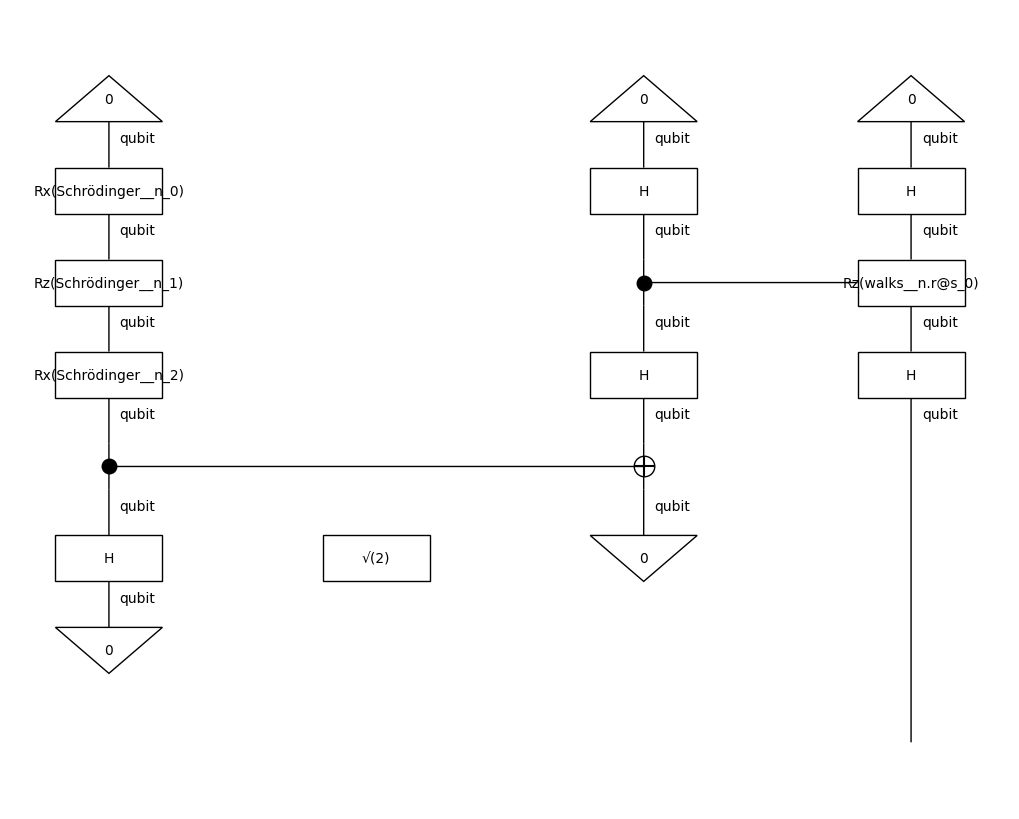

In [108]:
circuit.draw(figsize=(10, 8))

In [4]:
from lambeq import BobcatParser, IQPAnsatz
from discopy.tensor import Dim
from discopy.quantum import Circuit
import sympy
import numpy as np

In [9]:
# Step 1: Setup parser and ansatz
parser = BobcatParser()
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1, AtomicType.PREPOSITIONAL_PHRASE: 1}, n_layers=2)

# Step 2: Create diagram
sentence = "I found an abandoned bicycle in the alley."
diagram = parser.sentence2diagram(sentence)

# Step 3: Apply ansatz
circuit = ansatz(diagram)

In [39]:
from lambeq import BobcatParser, IQPAnsatz
import sympy

# Step 1: Initialize parser and ansatz
parser = BobcatParser()  # uses pre-trained grammar parser
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1, AtomicType.PREPOSITIONAL_PHRASE: 1}, n_layers=1)

# Step 2: Parse and build circuit
sentence = "a bicycle."
diagram = parser.sentence2diagram(sentence)
circuit = ansatz(diagram)

# ✅ Extract symbols (vocab)
vocab = sorted(circuit.free_symbols, key=str)
print("Symbols:")
for v in vocab:
    print(v)

# ✅ Define values in same order
values = [
    0.5,  # bicycle__n_1
    0.3,  # abandoned__n@n.l_0
    0.7,  # bicycle__n_2
    0.4,  # I__n_1
]

Symbols:
a__n@n.l_0
bicycle.__n_0
bicycle.__n_1
bicycle.__n_2


In [40]:
# ✅ Apply lambdify
evaluated_diagram = circuit.lambdify(*vocab)(*values)

# ✅ Evaluate final tensor
result = evaluated_diagram.eval()  # THIS is the working eval

# ✅ Print output
print("Sentence embedding:")
print(result)


Sentence embedding:
[ 0.41050988-0.25971044j -0.06501838-0.50971044j]


In [48]:
p = "A man is playing a red guitar"
q = "A man is playing a new guitar"
print(f"\nFor the sentence pair, p: {p}, q:{q}\n")
vec1 = [-0.09636267, 0.13054485]
vec2 = [ 0.41050988, -0.06501838]
compare_embeddings(vec1,vec2)


For the sentence pair, p: A man is playing a red guitar, q:A man is playing a new guitar

KL(p || q) = 0.525432
Representativeness R_KL(p || q) = 0.655552
KL(q || p) = 0.415933
Representativeness R_KL(q || p) = 0.706248
At threshold 0.8, p does not entails q.
At threshold 0.8, q does not entails p.
